####
We should put some if clauses such that if contract expires or there is a release clause our prediction is not made by the model, but we already know the transfer value
###

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.ensemble  import RandomForestRegressor
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from xgboost import XGBRegressor

In [2]:
# read files
from pathlib import Path
path = str(Path("andrea_models.ipynb").parent.absolute().parent.absolute()) + "/data/Final/ratings"
csv_files = glob.glob(os.path.join(path, "*.csv"))

# create one dataframe with ratings_20.csv and ratings_21.csv (train_valid dataframe), and one with ratings_22.csv (test dataframe)
train_valid = pd.concat([pd.read_csv(f) for f in csv_files[1:3]], ignore_index = True)
test = pd.read_csv(csv_files[0])


In [3]:
# save player_name in a variable
short_name_train_valid = train_valid["short_name"]
short_name_test = test["short_name"]

# drop the columns that are not needed
unnecessary_columns = ["short_name", "club_name", "year", "release_clause_eur"]
train_valid = train_valid.drop(unnecessary_columns, axis = 1)
test = test.drop(unnecessary_columns, axis = 1)

# divide value_eur and release_clause_eur by 1000000
train_valid["value_eur"] = train_valid["value_eur"]/1000000
#train_valid["release_clause_eur"] = train_valid["release_clause_eur"]/1000000
test["value_eur"] = test["value_eur"]/1000000
#test["release_clause_eur"] = test["release_clause_eur"]/1000000

# print them in new csv so we can use them in the other notebook
train_valid.to_csv("train_valid.csv", index = False)
test.to_csv("test.csv", index = False)

# define target and features
target = "value_eur"
features = [col for col in train_valid.columns if col != target]

# split into X and y
X_train_valid = train_valid[features]
y_train_valid = train_valid[target]

X_test = test[features]
y_test = test[target]

## Data pre-processing: fees and release clauses

In [4]:
# shapes of the datasets
print("train_valid shape: ", train_valid.shape)
print("test shape: ", test.shape)

train_valid shape:  (30872, 60)
test shape:  (16020, 60)


In [5]:
# display all columns
pd.set_option('display.max_columns', None)
X_train_valid.head()

,overall,potential,wage_eur,age,height_cm,weight_kg,league_level,club_joined,club_contract_valid_until,preferred_foot,weak_foot,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position_A,position_D,position_G,position_M,attack_work_rate,defense_work_rate
0,93,93,560000.0,33,170,72,1.0,2004,2021.0,0,4,4,5,85.0,92.0,91.0,95.0,38.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8,1,0,0,0,2,1
1,92,92,220000.0,35,187,83,1.0,2004,2022.0,1,4,5,5,89.0,93.0,81.0,89.0,35.0,77.0,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11,1,0,0,0,3,1
2,91,91,240000.0,31,184,80,1.0,2004,2023.0,1,4,4,4,78.0,91.0,78.0,85.0,43.0,82.0,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,35,42,19,15,6,12,8,10,1,0,0,0,3,2
3,91,91,270000.0,28,175,68,1.0,2004,2022.0,1,5,5,5,91.0,85.0,86.0,94.0,36.0,59.0,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,35,30,29,9,9,15,15,11,1,0,0,0,3,2
4,91,91,370000.0,29,181,70,1.0,2004,2023.0,1,5,4,4,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,94,82,88,85,83,93,92,77,76,78,91,76,91,63,89,74,91,76,66,88,94,84,91,68,65,53,15,13,5,10,13,0,0,0,1,3,3


In [6]:
# correlation between features and target
corr = train_valid.corr()
corr["value_eur"].sort_values(ascending = False)

value_eur                      1.000000
wage_eur                       0.819151
overall                        0.590880
international_reputation       0.570438
potential                      0.553659
movement_reactions             0.531393
mentality_composure            0.474019
skill_ball_control             0.456948
attacking_short_passing        0.446280
passing                        0.421010
dribbling                      0.407017
skill_dribbling                0.368797
mentality_vision               0.365920
skill_long_passing             0.346554
skill_moves                    0.340994
power_shot_power               0.326892
skill_curve                    0.325884
shooting                       0.314402
mentality_positioning          0.309665
attacking_volleys              0.305416
power_long_shots               0.302768
attacking_crossing             0.302669
attacking_finishing            0.270401
skill_fk_accuracy              0.267869
power_stamina                  0.261031


In [16]:
# show how many value_eur are less than 1
train_valid[train_valid["value_eur"] < 1].shape
test[test["value_eur"] < 1].shape

(7911, 60)

## Define functions that will be used across models

In [17]:
def compute_results(y_pred, y_true):
    """
    Compute the results of the model
    """
    # compute the mean absolute error
    mae = np.mean(abs(y_pred - y_true))
    
    # compute the mean squared error
    mse = np.mean((y_pred - y_true) ** 2)
    
    # compute the root mean squared error
    rmse = np.sqrt(mse)
    
    # compute the mean absolute percentage error
    mape = np.mean(abs((y_pred - y_true) / y_true))
    
    # compute the coefficient of determination
    r2 = 1 - (np.sum((y_pred - y_true) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    # store the results in a dataframe
    results = pd.DataFrame({"mae": [mae], "mse": [mse], "rmse": [rmse], "mape": [mape], "r2": [r2]})

    return results


def plot_results(y_pred, y_true):
    
    # plot both distributions
    figure(figsize = (10, 8))
    plt.hist(y_pred, bins = 100, alpha = 0.5, label = "Predicted")
    plt.hist(y_true, bins = 100, alpha = 0.5, label = "True")
    plt.legend(loc = "upper right")
    plt.title("Predicted vs True Distributions")
    plt.show()

    # plot the predicted vs true
    figure(figsize = (10, 8))
    plt.scatter(y_pred, y_true)
    plt.title("Predicted vs True")
    plt.show()

## Linear Regression

In [18]:
def LinearRegression_model(X_train_valid, y_train_valid, X_test, y_test):

    # define model
    model = LinearRegression()

    # fit the model
    model.fit(X_train_valid, y_train_valid)

    # predict on the test set
    y_pred = model.predict(X_test)
    
    # negative values are not allowed
    y_pred[y_pred < 0] = 0

    # compute the results
    train_results = compute_results(model.predict(X_train_valid), y_train_valid)
    test_results = compute_results(y_pred, y_test)

    # plot the results
    plot_results(y_pred, y_test)

    # store the results in the same dataframe
    results = pd.concat([train_results, test_results], axis = 0)
    # add a column with "training set" and "test set"
    results["set"] = ["train set", "test set"]
    # put this column in the first position
    results = results[["set", "mae", "mse", "rmse", "mape", "r2"]]

    print("Linear Regression Results: ")
    print(results)

    return model

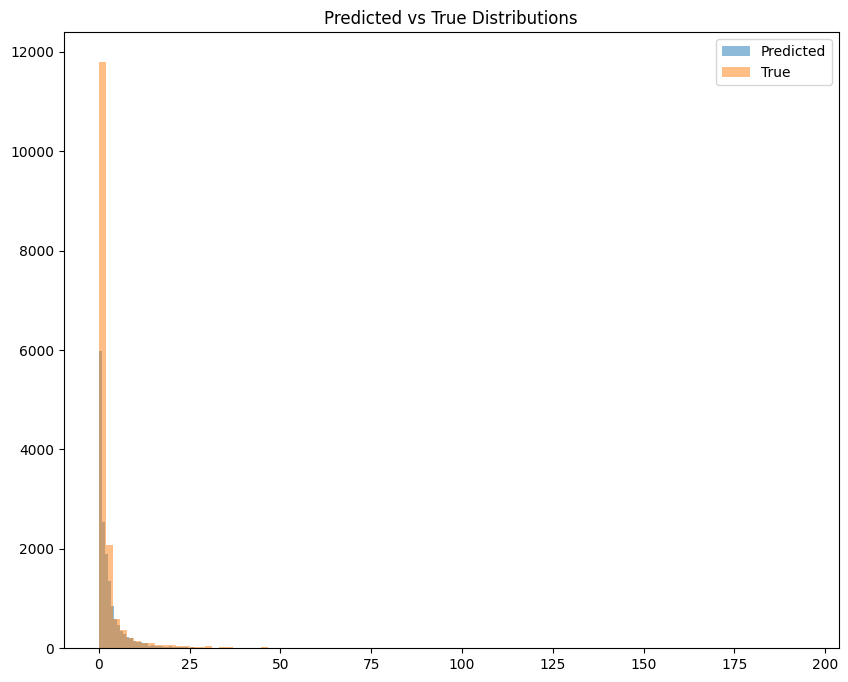

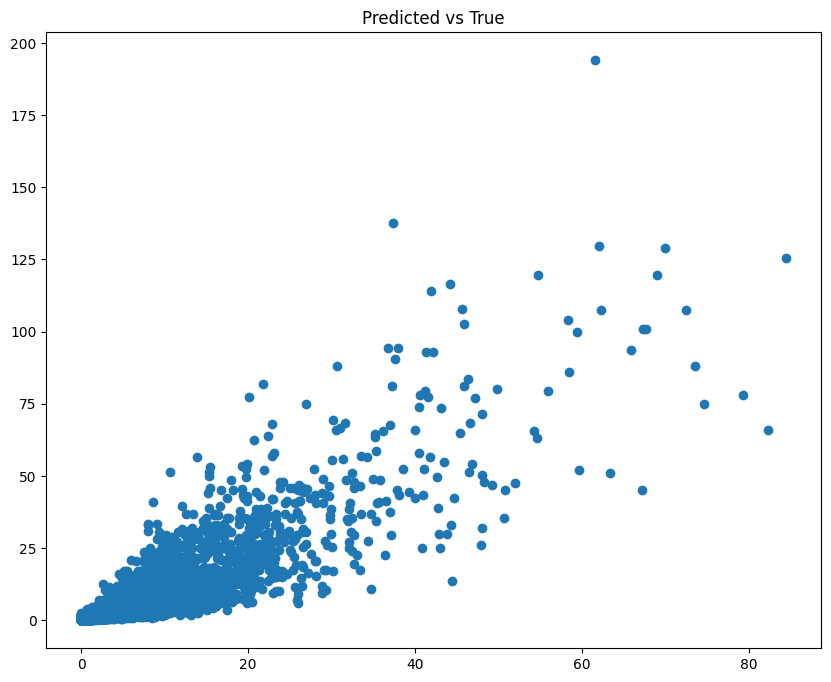

Linear Regression Results: 
         set       mae        mse      rmse      mape        r2
0  train set  1.683454  13.581749  3.685342  2.518254  0.721553
0   test set  1.582628  17.269795  4.155694  0.808069  0.719502


In [19]:
Linear_model = LinearRegression_model(X_train_valid, y_train_valid, X_test, y_test)

In [20]:
linear_pred = Linear_model.predict(X_test)
# negative values are not allowed
linear_pred[linear_pred < 0].shape

(3450,)

## Lasso Regression

In [32]:
def Lasso_model(X_train_valid, y_train_valid, X_test, y_test):

    # define model
    model = LassoCV(cv=5, random_state=0) # 5-fold cross validation to select the best alpha

    # fit the model
    model.fit(X_train_valid, y_train_valid)

    # predict on the test set
    y_pred = model.predict(X_test)

    # negative values are not allowed
    y_pred[y_pred < 0] = 0

    # compute the results
    train_results = compute_results(model.predict(X_train_valid), y_train_valid)
    test_results = compute_results(y_pred, y_test)

    # plot the results
    plot_results(y_pred, y_test)

    # store the results in the same dataframe
    results = pd.concat([train_results, test_results], axis = 0)
    # add a column with "training set" and "test set"
    results["set"] = ["train set", "test set"]
    # put this column in the first position
    results = results[["set", "mae", "mse", "rmse", "mape", "r2"]]

    print("Lasso Regression Results: ")
    print(results)

    return model


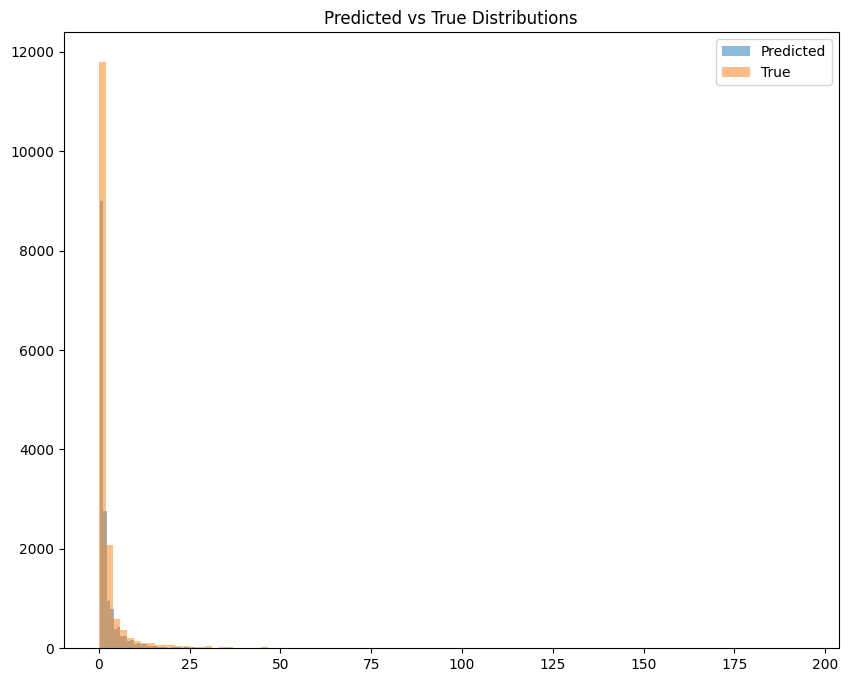

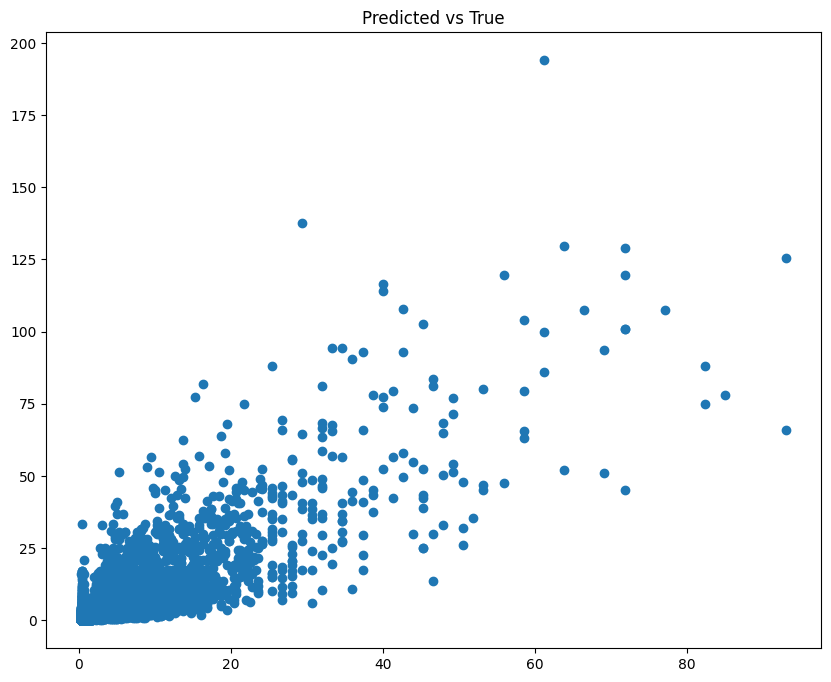

Lasso Regression Results: 
         set       mae        mse      rmse      mape        r2
0  train set  1.493380  16.049276  4.006155  1.019334  0.670965
0   test set  1.567513  20.654812  4.544757  0.784181  0.664522


In [33]:
Lasso_model = Lasso_model(X_train_valid, y_train_valid, X_test, y_test)

## Random Forest

In [34]:
def RandomForest_model(X_train_valid, y_train_valid, X_test, y_test):

    # define model
    model = RandomForestRegressor(n_estimators = 200, random_state=0)

    # define parameters
    parameters = {"max_depth": [10, 15, 20],
                  "min_samples_split": [2, 5, 10],
                  "max_features": [10, 15, 20],
                  }

    # use random search to find the best parameters
    grid = RandomizedSearchCV(model, parameters, cv = 5, n_iter = 10, random_state = 0)

    # use only 10% of the data to speed up the computation
    X_train_valid = X_train_valid.sample(frac = 0.1, random_state = 0)
    y_train_valid = y_train_valid.sample(frac = 0.1, random_state = 0)
    X_test = X_test.sample(frac = 0.1, random_state = 0)
    y_test = y_test.sample(frac = 0.1, random_state = 0)

    # fit the model
    grid.fit(X_train_valid, y_train_valid)

    # predict on the test set
    y_pred = grid.predict(X_test)

    # negative values are not allowed
    y_pred[y_pred < 0] = 0

    # compute the results
    train_results = compute_results(grid.predict(X_train_valid), y_train_valid)
    test_results = compute_results(y_pred, y_test)

    # plot the results
    plot_results(y_pred, y_test)

    # store the results in the same dataframe
    results = pd.concat([train_results, test_results], axis = 0)
    # add a column with "training set" and "test set"
    results["set"] = ["train set", "test set"]
    # put this column in the first position
    results = results[["set", "mae", "mse", "rmse", "mape", "r2"]]

    print("Random Forest Results: ")
    print(results)

    # return results and model
    return grid.best_estimator_


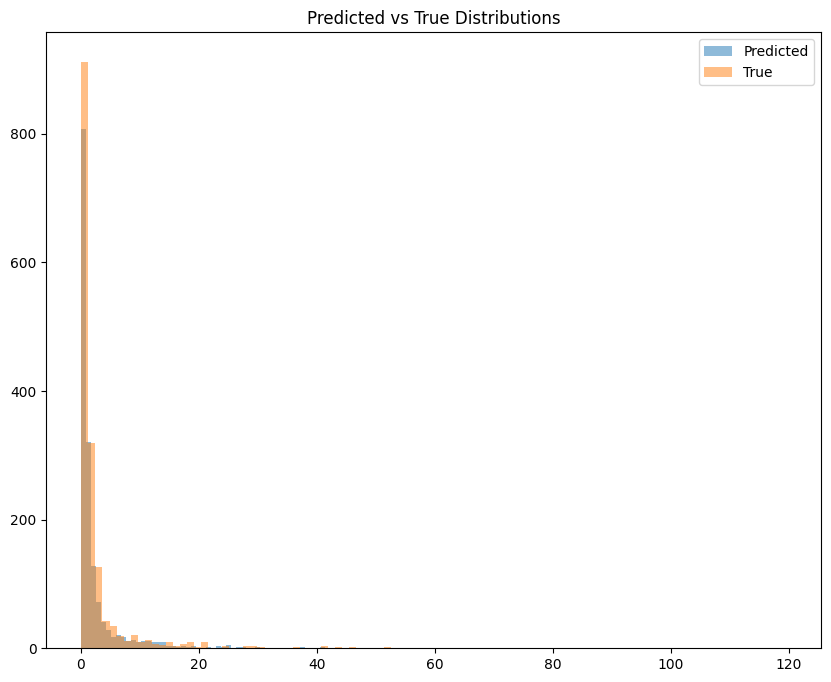

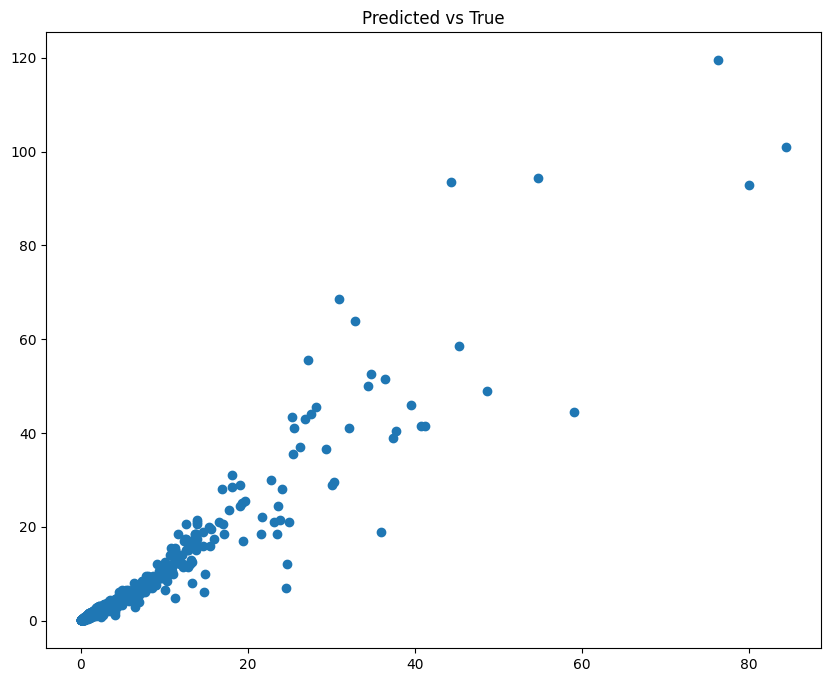

Random Forest Results: 
         set       mae       mse      rmse      mape        r2
0  train set  0.221616  0.812446  0.901358  0.098753  0.985335
0   test set  0.712721  9.420981  3.069362  0.170862  0.874540


In [35]:
RF_model = RandomForest_model(X_train_valid, y_train_valid, X_test, y_test)

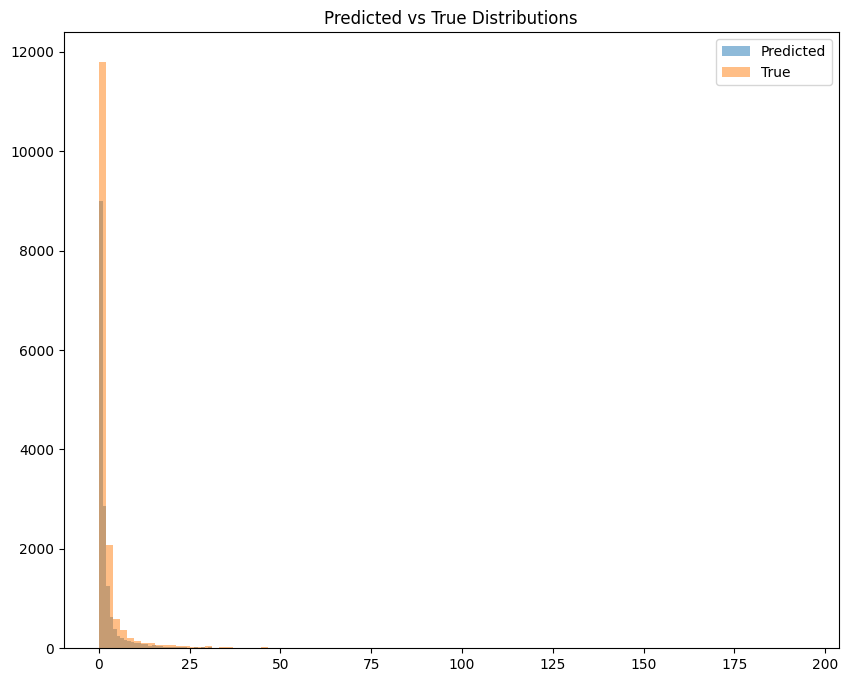

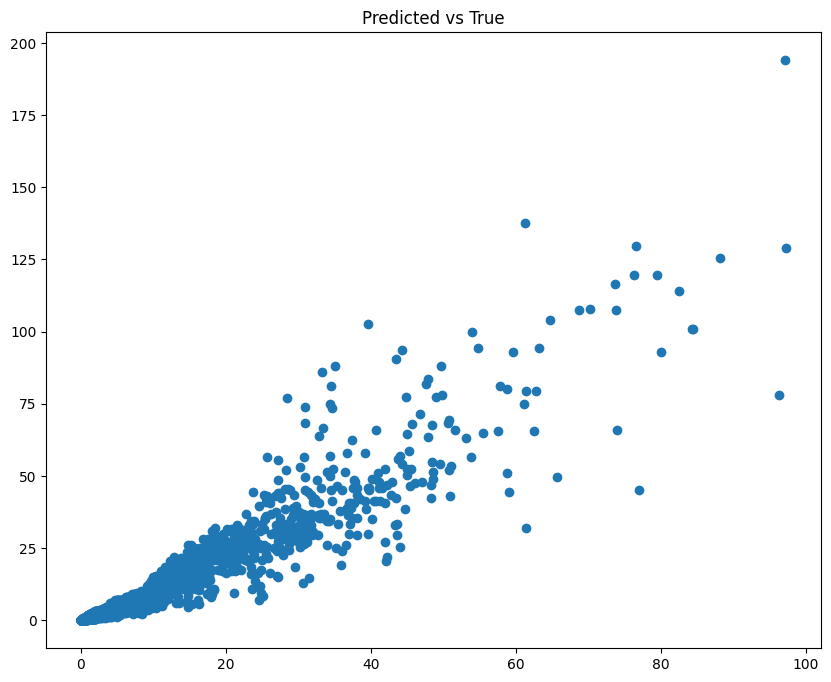

,set,mae,mse,rmse,mape,r2
0,train set,0.539138,4.824902,2.196566,0.24616,0.901082
0,test set,0.604196,7.492135,2.737176,0.18604,0.878312


In [36]:
y_pred = RF_model.predict(X_test)

# compute the results
train_results = compute_results(RF_model.predict(X_train_valid), y_train_valid)
test_results = compute_results(y_pred, y_test)

# plot the results
plot_results(y_pred, y_test)

# store the results in the same dataframe
results = pd.concat([train_results, test_results], axis = 0)
# add a column with "training set" and "test set"
results["set"] = ["train set", "test set"]
# put this column in the first position
results = results[["set", "mae", "mse", "rmse", "mape", "r2"]]

results

In [37]:
# print feature importance of the random forest model
importances = pd.DataFrame({"feature": X_train_valid.columns, "importance": RF_model.feature_importances_})
importances = importances.sort_values("importance", ascending = False)
importances

,feature,importance
0,overall,0.303548
1,potential,0.149766
2,wage_eur,0.134646
28,skill_ball_control,0.094411
32,movement_reactions,0.045456
22,attacking_short_passing,0.038601
15,passing,0.034410
16,dribbling,0.025563
42,mentality_vision,0.022434
24,skill_dribbling,0.013742


In [42]:
# save the model
import pickle
pickle.dump(RF_model, open("RF_model.pkl", "wb"))

# load the model
#RF_model = pickle.load(open("RF_model.pkl", "rb"))

## XGBoost

In [45]:
def XGBoost_model(X_train_valid, y_train_valid, X_test, y_test):

    #  define model
    model = XGBRegressor(n_estimators = 200, random_state=0)

    # define parameters
    parameters = {"max_depth": [4, 6, 10],
                  "alpha": [0, 0.1, 0.3],
                  "eta": [0.001, 0.1, 0.3],
                  }

    # define random search
    grid = RandomizedSearchCV(model, parameters, cv = 5, n_iter = 10, random_state = 0)

    # use only 10% of the data to speed up the computation
    X_train_valid = X_train_valid.sample(frac = 0.1, random_state = 0)
    y_train_valid = y_train_valid.sample(frac = 0.1, random_state = 0)
    X_test = X_test.sample(frac = 0.1, random_state = 0)
    y_test = y_test.sample(frac = 0.1, random_state = 0)

    # fit the model
    grid.fit(X_train_valid, y_train_valid)

    # predict on the test set
    y_pred = grid.predict(X_test)

    # negative values are not allowed
    y_pred[y_pred < 0] = 0

    # compute the results
    train_results = compute_results(grid.predict(X_train_valid), y_train_valid)
    test_results = compute_results(y_pred, y_test)

    # plot the results
    plot_results(y_pred, y_test)

    # store the results in the same dataframe
    results = pd.concat([train_results, test_results], axis = 0)
    # add a column with "training set" and "test set"
    results["set"] = ["train set", "test set"]
    # put this column in the first position
    results = results[["set", "mae", "mse", "rmse", "mape", "r2"]]

    print("XGBoost Results: ")
    print(results)

    return grid.best_estimator_

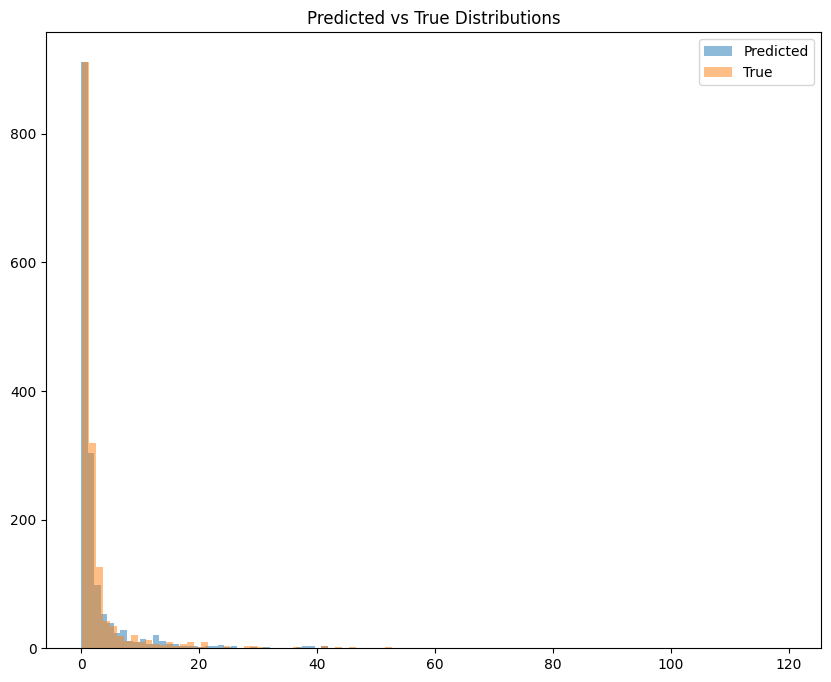

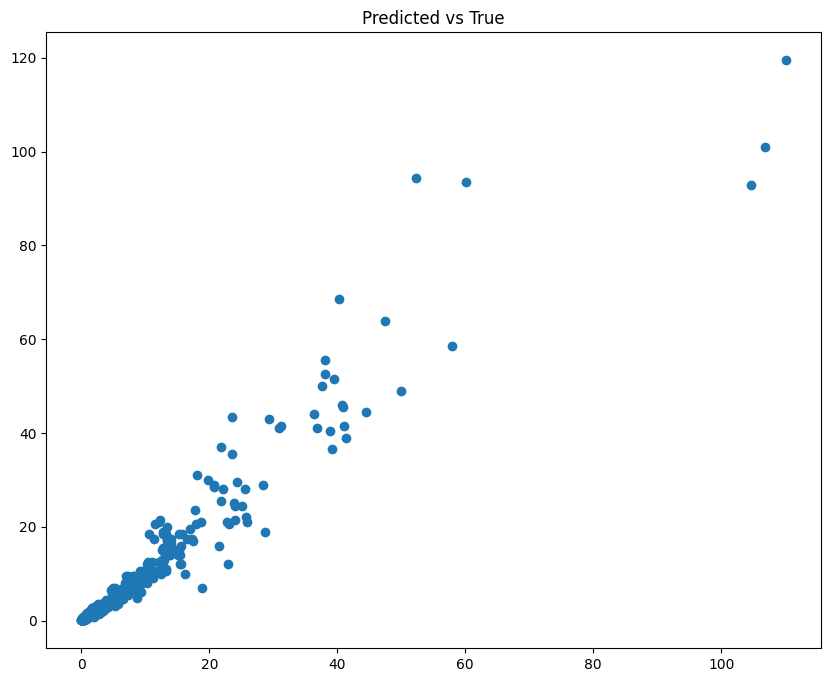

XGBoost Results: 
         set       mae       mse      rmse      mape        r2
0  train set  0.077344  0.011311  0.106353  0.110499  0.999796
0   test set  0.593391  5.193168  2.278852  0.180871  0.930842


In [46]:
XGB_model = XGBoost_model(X_train_valid, y_train_valid, X_test, y_test)

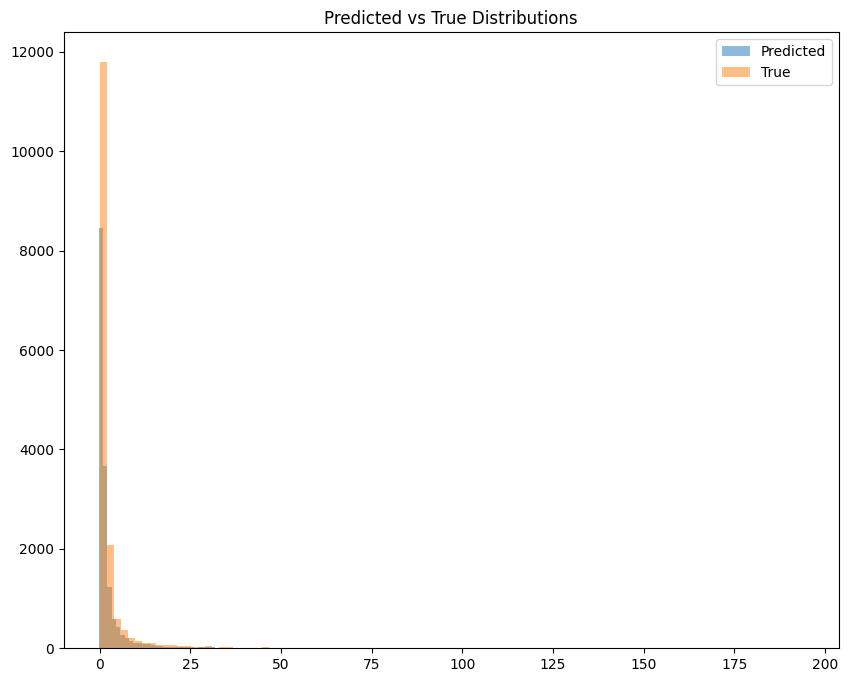

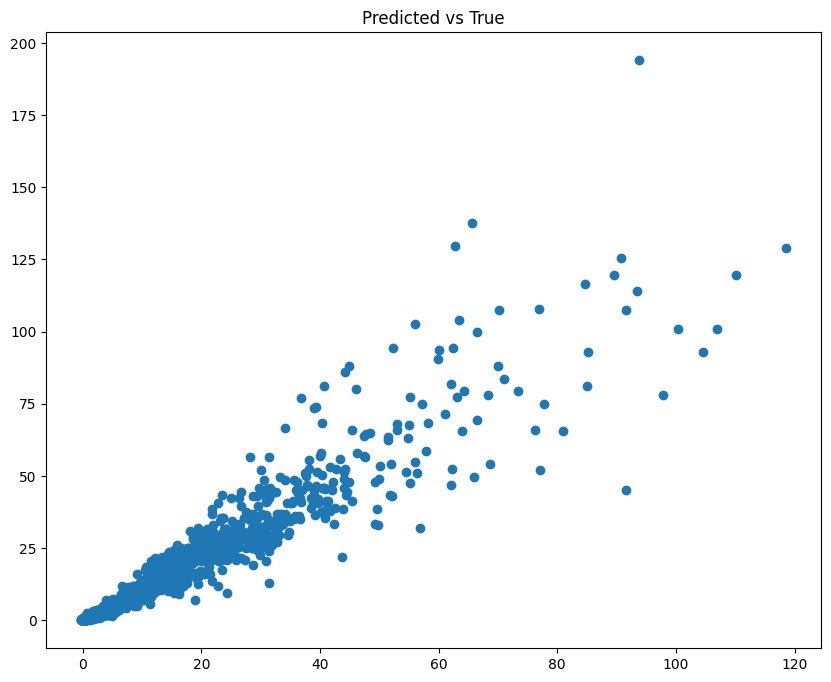

,set,mae,mse,rmse,mape,r2
0,train set,0.495523,4.069560,2.017315,0.230905,0.916568
0,test set,0.513806,5.255883,2.292571,0.188003,0.914633


In [47]:
y_pred = XGB_model.predict(X_test)

# compute the results
train_results = compute_results(XGB_model.predict(X_train_valid), y_train_valid)
test_results = compute_results(y_pred, y_test)

# plot the results
plot_results(y_pred, y_test)

# store the results in the same dataframe
results = pd.concat([train_results, test_results], axis = 0)
# add a column with "training set" and "test set"
results["set"] = ["train set", "test set"]
# put this column in the first position
results = results[["set", "mae", "mse", "rmse", "mape", "r2"]]

results

In [48]:
# print feature importance of the xgboost model
importances = pd.DataFrame({"feature": X_train_valid.columns, "importance": XGB_model.feature_importances_})
importances = importances.sort_values("importance", ascending = False)
importances

,feature,importance
0,overall,0.635352
1,potential,0.084532
28,skill_ball_control,0.075631
4,height_cm,0.036757
3,age,0.016417
13,pace,0.014218
42,mentality_vision,0.013004
58,defense_work_rate,0.012174
21,attacking_heading_accuracy,0.012112
41,mentality_positioning,0.012021


In [49]:
# save the model
import pickle
pickle.dump(XGB_model, open("XGB_model.pkl", "wb"))

# load the model
#XGB_model = pickle.load(open("XGB_model.pkl", "rb"))